In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install rasterio whitebox geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import networkx as nx
import matplotlib.pyplot as plt
import whitebox
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm

## Config

In [ ]:
DRIVE_ROOT = '/content/drive/My Drive'
PROJECT_DIR = os.path.join(DRIVE_ROOT, 'Oyster_Flow')
RESULT_DIR = os.path.join(PROJECT_DIR, 'OFG_result')
os.makedirs(RESULT_DIR, exist_ok=True)

flow_accum = os.path.join(PROJECT_DIR, 'FlowAcc_Flow51.tif')
flow_dir = os.path.join(PROJECT_DIR, 'FlowDir_Fill31.tif')

streams_rast = os.path.join(RESULT_DIR, 'HS_slope_streams.tif')
stream_order_r = os.path.join(RESULT_DIR, 'HS_slope_order.tif')

base_dir = os.path.join(PROJECT_DIR, 'OFG_New')
env_vars = ['w1', 'v1', 'temp1', 'NO32', 'chlorophyll1', 'salt1']
display_names = {'NO32': 'NO$_3$2'}

basin_shp = os.path.join(PROJECT_DIR, 'OFG_New', 'oysterbasin0325.shp')

THRESHOLDS = list(range(35))

wbt = whitebox.WhiteboxTools()
wbt.set_working_dir(RESULT_DIR)

Decompressing WhiteboxTools_linux_musl.zip ...
WhiteboxTools package directory: /usr/local/lib/python3.12/dist-packages/whitebox


## Helpers

In [ ]:
def load_env_arrays(var_list, base_directory):
    arrays = {}
    for v in var_list:
        path = os.path.join(base_directory, f'{v}.tif')
        with rasterio.open(path) as src:
            arr = src.read(1).astype(np.float32)
            if src.nodata is not None:
                arr = np.where(arr == src.nodata, np.nan, arr)
        arrays[v] = arr
    return arrays

def extract_graph(threshold):
    wbt.extract_streams(flow_accum, streams_rast, threshold)
    wbt.strahler_stream_order(d8_pntr=flow_dir, streams=streams_rast, output=stream_order_r)

    with rasterio.open(streams_rast) as src:
        streams_data = src.read(1).astype(np.float32)
        transform = src.transform
        streams_crs = src.crs
    with rasterio.open(flow_accum) as src:
        flow_acc_data = src.read(1).astype(np.float32)
    with rasterio.open(stream_order_r) as src:
        stream_order_data = src.read(1).astype(np.float32)

    flow_acc_data[flow_acc_data < 0] = 0

    graph = nx.Graph()
    rows, cols = np.where(streams_data > 0)
    for r, c in zip(rows, cols):
        graph.add_node((r, c), flow_acc=flow_acc_data[r, c], stream_order=stream_order_data[r, c])
    for r, c in zip(rows, cols):
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < streams_data.shape[0] and 0 <= nc < streams_data.shape[1]:
                if streams_data[nr, nc] > 0:
                    graph.add_edge((r, c), (nr, nc))
    return graph, transform, streams_crs

def assign_basins(graph, transform, streams_crs, basins):
    node_list = []
    for node in graph.nodes():
        r, c = node
        lon, lat = rasterio.transform.xy(transform, r, c)
        node_list.append({'node': node, 'lon': lon, 'lat': lat})
    node_df = pd.DataFrame(node_list)
    node_gdf = gpd.GeoDataFrame(
        node_df,
        geometry=[Point(xy) for xy in zip(node_df['lon'], node_df['lat'])],
        crs=streams_crs
    )
    node_basins = gpd.sjoin(node_gdf, basins, how='left', predicate='within')
    if 'basin_id' not in node_basins.columns:
        node_basins['basin_id'] = node_basins.index_right
    node_basins = node_basins.dropna(subset=['basin_id'])
    node_basins['basin_id'] = node_basins['basin_id'].astype(int)
    return node_basins

def basin_metrics(graph, node_basins):
    rows = []
    for bid in node_basins['basin_id'].unique():
        subset = node_basins[node_basins['basin_id'] == bid]
        nodes_in_basin = subset['node'].tolist()
        subgraph = graph.subgraph(nodes_in_basin)
        if len(subgraph) < 2:
            continue
        connectivity = nx.number_connected_components(subgraph)
        flow_eff = float(np.mean([d['flow_acc'] for _, d in subgraph.nodes(data=True)]))
        deg_cent = nx.degree_centrality(subgraph)
        avg_deg = float(np.mean(list(deg_cent.values())))
        avg_order = float(np.mean([d['stream_order'] for _, d in subgraph.nodes(data=True)]))
        rows.append({
            'basin_id': bid,
            'Connectivity': connectivity,
            'Flow_Efficiency': flow_eff,
            'Degree_Centrality': avg_deg,
            'Stream_Order': avg_order,
        })
    return pd.DataFrame(rows)

def basin_env_means(node_basins, env_arrays):
    env_rows = []
    for bid in node_basins['basin_id'].unique():
        sub = node_basins[node_basins['basin_id'] == bid]
        vals = {'basin_id': bid}
        for v, arr in env_arrays.items():
            vs = []
            for node in sub['node']:
                r, c = node
                try:
                    vs.append(float(arr[r, c]))
                except Exception:
                    pass
            vals[v] = float(np.nanmean(vs)) if vs else np.nan
        env_rows.append(vals)
    return pd.DataFrame(env_rows)


## Degree_Centrality vs env at th=0

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='0' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 

/tmp/ipython-input-439854658.py:93: RuntimeWarning: Mean of empty slice
  vals[v] = float(np.nanmean(vs)) if vs else np.nan
/tmp/ipython-input-439854658.py:93: RuntimeWarning: Mean of empty slice
  vals[v] = float(np.nanmean(vs)) if vs else np.nan
/tmp/ipython-input-439854658.py:93: RuntimeWarning: Mean of empty slice
  vals[v] = float(np.nanmean(vs)) if vs else np.nan
/tmp/ipython-input-439854658.py:93: RuntimeWarning: Mean of empty slice
  vals[v] = float(np.nanmean(vs)) if vs else np.nan
/tmp/ipython-input-439854658.py:93: RuntimeWarning: Mean of empty slice
  vals[v] = float(np.nanmean(vs)) if vs else np.nan
/tmp/ipython-input-439854658.py:93: RuntimeWarning: Mean of empty slice
  vals[v] = float(np.nanmean(vs)) if vs else np.nan
/tmp/ipython-input-439854658.py:93: RuntimeWarning: Mean of empty slice
  vals[v] = float(np.nanmean(vs)) if vs else np.nan
/tmp/ipython-input-1808081086.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

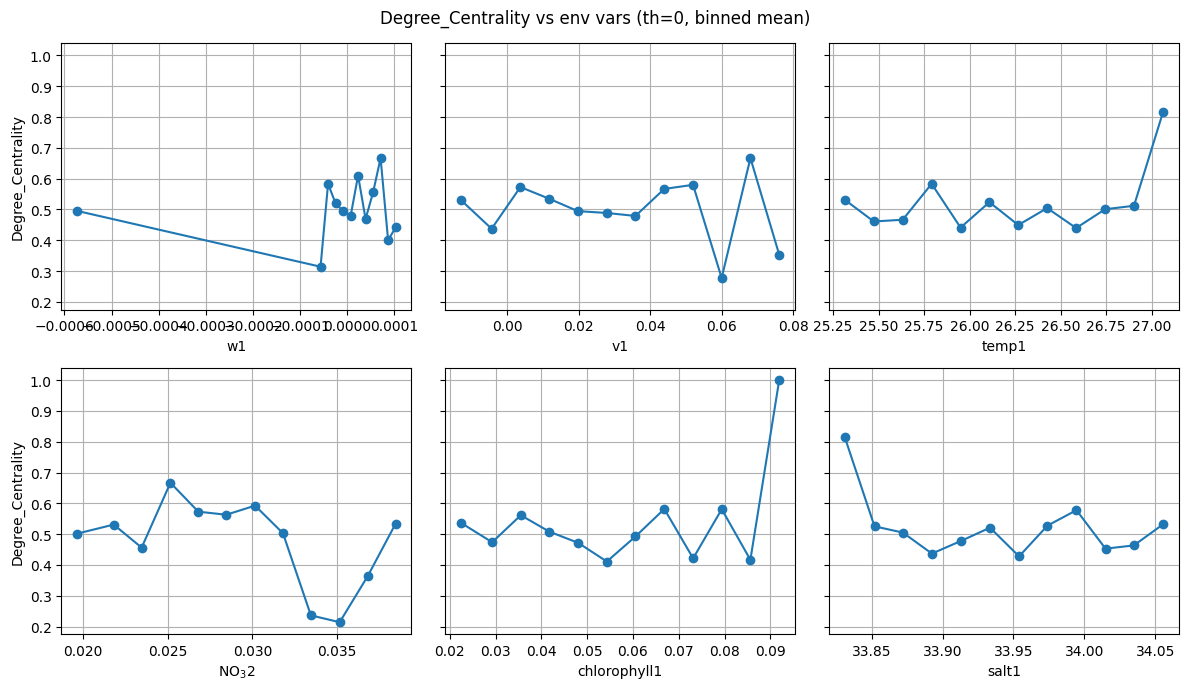

In [ ]:
env_arrays = load_env_arrays(env_vars, base_dir)
basins = gpd.read_file(basin_shp)
graph, transform, streams_crs = extract_graph(0)
node_basins = assign_basins(graph, transform, streams_crs, basins)
bdf = basin_metrics(graph, node_basins)
env_df = basin_env_means(node_basins, env_arrays)
df_env = bdf.merge(env_df, on='basin_id', how='left')

# Degree_Centrality binned-mean curves vs env (th=0)
m = 'Degree_Centrality'
fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharey=True)
axes = axes.flatten()
for i, var in enumerate(env_vars):
    ax = axes[i]
    sub = df_env[[var, m]].dropna()
    if sub.empty:
        ax.set_xlabel(display_names.get(var, var))
        if i % 3 == 0:
            ax.set_ylabel(m)
        ax.grid(True)
        continue
    bin_count = 12
    bins = np.linspace(sub[var].min(), sub[var].max(), bin_count + 1)
    sub['env_bin'] = pd.cut(sub[var], bins=bins, include_lowest=True)
    binned = sub.groupby('env_bin')[m].mean().reset_index()
    binned['env_center'] = binned['env_bin'].apply(lambda x: (x.left + x.right) / 2)

    ax.plot(binned['env_center'], binned[m], marker='o', linestyle='-')
    ax.set_xlabel(display_names.get(var, var))
    if i % 3 == 0:
        ax.set_ylabel(m)
    ax.grid(True)
plt.suptitle('Degree_Centrality vs env vars (th=0, binned mean)')
plt.tight_layout()
out_pdf = os.path.join(RESULT_DIR, 'Degree_Centrality_vs_env_th_0_binned_mean_0107.pdf')
plt.savefig(out_pdf, bbox_inches='tight')
plt.show()
